<a href="https://colab.research.google.com/github/ZachGermain/DSPS_zgermain/blob/master/HW6_zGermain/SNdataLineFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Objective: fit supernova cosmology data : the linear relationship between logarithm redshift and luminosity of supernovae is evidence of the expansion of the Universe. In this homework you will fit the supernova data with a line, in the next class we will discover evidence of the *accelerated* expansion of the Universe

# Get the data

Download the supernova (SN) data used in the Betoule 2014 paper https://arxiv.org/abs/1401.4064. The data can be obtained here 
http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html

As it says on the webpage: "The JLA C++ code and data are available from a single archive: jla_likelihood_v6.tgz". 
Download it and unpack it (untar unzip) within the notebook (mounting your drive on colab etc) and move the data to the folder /drive/My Drive/dsps/data

The input data file is named jla_lcparams.txt


In [137]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pylab as pl
import scipy.optimize as opt
import sklearn.model_selection as sklMod
import sklearn.linear_model as sklLin

In [0]:
jla = pd.read_csv("drive/My Drive/dsps/data/jla_likelihood_v6/data/jla_lcparams.txt", sep=" ")

In [140]:
jla.head()

,#name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,3rdvar,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
0,03D1au,0.503084,0.5043,0,23.001698,0.088031,1.273191,0.150058,-0.012353,0.030011,9.517,0.1105,52909.745220,0.214332,0.000790,0.000440,-0.000030,1,36.043210,-4.037469,0.001697
1,03D1aw,0.580724,0.5820,0,23.573937,0.090132,0.974346,0.273823,-0.025076,0.036691,9.169,0.0880,52902.898002,0.352732,0.002823,0.000415,0.001574,1,36.061634,-4.517158,0.000843
2,03D1ax,0.494795,0.4960,0,22.960139,0.088110,-0.728837,0.102069,-0.099683,0.030305,11.580,0.1125,52915.923670,0.111634,0.000542,0.000475,-0.000024,1,36.097287,-4.720774,0.001692
3,03D1bp,0.345928,0.3470,0,22.398137,0.087263,-1.155110,0.112834,-0.040581,0.026679,10.821,0.1235,52920.249015,0.102828,0.001114,0.000616,0.000295,1,36.657235,-4.838779,-0.000270
4,03D1co,0.677662,0.6790,0,24.078115,0.098356,0.618820,0.404295,-0.039380,0.067403,8.647,0.2840,52954.458342,0.454715,0.011857,0.000780,0.005898,1,36.567748,-4.935050,-0.002855


In [141]:
jla.describe()

,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,3rdvar,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
count,740.000000,740.000000,740.0,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,0.323804,0.324449,0.0,20.904956,0.115913,0.036599,0.311099,-0.023862,0.038897,9.795341,0.827140,53527.309187,0.382252,0.006210,0.000645,0.002665,1.860811,93.551713,5.726200,-0.004195
std,0.276869,0.276748,0.0,2.655143,0.018761,0.988559,0.211398,0.084112,0.015706,1.395068,3.369119,1023.254711,0.299172,0.010127,0.000947,0.005317,0.715821,119.504602,22.728815,0.006796
min,0.010060,0.009370,0.0,14.148421,0.085341,-2.862959,0.017738,-0.250149,0.011882,5.000000,0.004500,48076.401017,0.021321,-0.044995,-0.004558,-0.011397,1.000000,-55.207462,-66.485085,-0.036389
25%,0.124240,0.124418,0.0,19.735791,0.101604,-0.650131,0.148408,-0.084578,0.026015,9.316750,0.106875,53360.155972,0.164968,0.000646,0.000440,0.000061,1.000000,4.812357,-1.037904,-0.008439
50%,0.229045,0.230515,0.0,21.098947,0.114480,0.165391,0.267931,-0.030434,0.034759,10.193500,0.182750,53685.973783,0.307975,0.003097,0.000630,0.000919,2.000000,36.667567,0.237261,-0.001083
75%,0.498216,0.499000,0.0,23.043200,0.124173,0.775606,0.420354,0.030961,0.049647,10.710250,0.290500,54041.338277,0.509950,0.008213,0.000971,0.003591,2.000000,190.881058,2.146795,-0.000380
max,1.299106,1.300000,0.0,26.046776,0.174566,2.337170,1.641345,0.259538,0.106505,11.817000,54.194000,54555.109466,2.336975,0.069409,0.008604,0.053578,4.000000,359.635090,79.031740,0.002649


In [142]:
jla.columns

Index(['#name', 'zcmb', 'zhel', 'dz', 'mb', 'dmb', 'x1', 'dx1', 'color',
       'dcolor', '3rdvar', 'd3rdvar', 'tmax', 'dtmax', 'cov_m_s', 'cov_m_c',
       'cov_s_c', 'set', 'ra', 'dec', 'biascor'],
      dtype='object')

Use pandas scatter matrix to see the relationship between variables (Lab6). If you look in HW5 you can see how to rotate the labels

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[i])


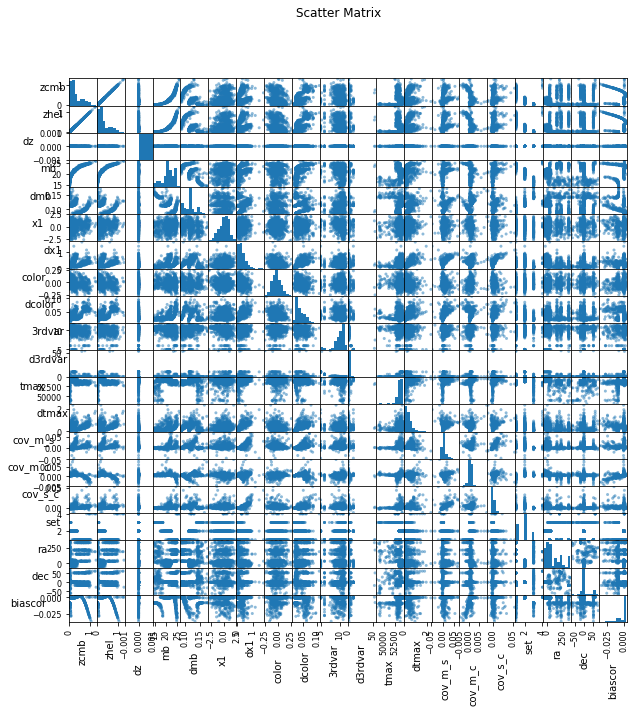

In [143]:
axs = pd.plotting.scatter_matrix(jla, figsize=(10,10));
for x in range(len(axs)):
    for y in range(len(axs)):
        if x == len(axs) - 1:
            #to make x axis name vertical  
            axs[x, y].xaxis.label.set_rotation(90);
        if y == 0:    
            axs[x, y].yaxis.label.set_rotation(0);
pl.suptitle("Scatter Matrix");

This is a scatter matrix looking at the relationships with the columns.

The target variables for our analysis are redshift and brightness: "zcmb" and "mb". This an exercise about fitting lines to data. Why does it lot look like there is a line relationship between them? How can does the relationship look? Plot the "zcmb" vs "mb". Include the y uncertainty which is reported in "dmb". Plot each data point with a different color based on the survey it comes from. The survey data is indicated by the variable "set". To do it you can use the dataframe plotting methods (```df.plot.scatter()```),  or pylab:  ```pylab.scatter()```, or ```pylab.plot()``` --asking to plot the data as point ('.')-- but for each the way you relate the color to a column value is a bit different. Stackoverflow is your friend here!

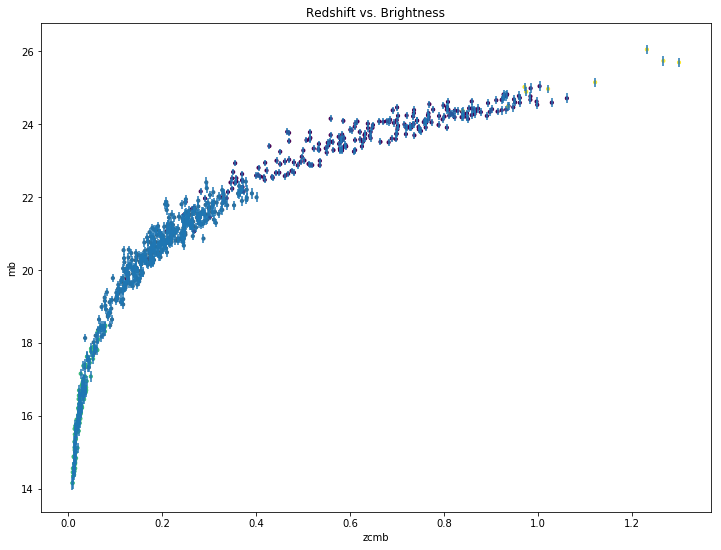

In [144]:
scat = jla.plot.scatter(x = 'zcmb', y = 'mb', yerr='dmb', s = 10, c = 'set',
                        colormap='viridis', figsize=(12,9), colorbar=False,
                       title='Redshift vs. Brightness');

This figure is a scatter plot of redshift (zcmb) vs. brighteness(mb). Error bars are also added for the brightness. The points are colored based on their survey set. A fit for this would be monotonically increasing.

It is a **power law**, which means it will be linear in logarithmic space - specifically in log10(_x_) vs natural _y_ space.

Replot the data with natural y axis and logarithmic x axis, you can do that by taking the log of the data and then plotting it or by using plot functionalities (e.g. for ```df.plot.scatter()``` you can use ```logx=True```)

Note that when we talk about log we (generally) talk about log base 10! 


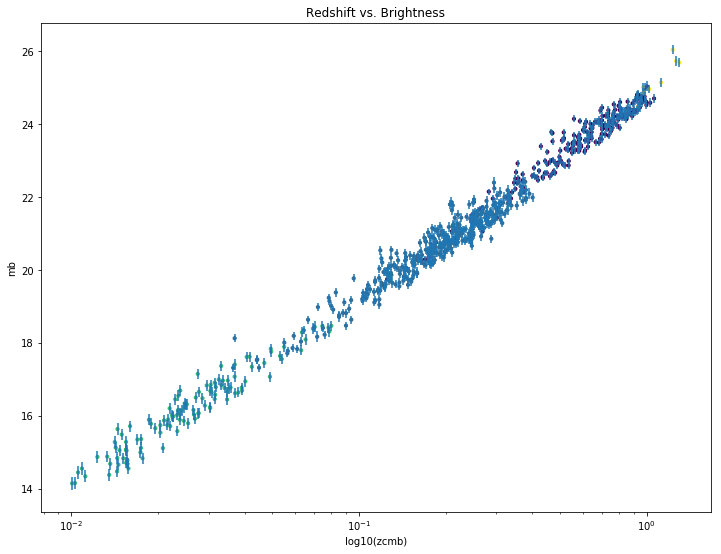

In [145]:
scat2 = jla.plot.scatter(x = 'zcmb', y = 'mb', yerr='dmb', s = 10, c = 'set',
                        colormap='viridis', figsize=(12,9), colorbar=False,
                       title='Redshift vs. Brightness', logx=True);
scat2.set_xlabel("log10(zcmb)");

This is a scatter plot of redshift(log10(zcmb)) vs brightness(mb). The redshift is plotted as a log. Since the scatter looks linear, and redshift is plotted as log10, their must be a power law relationship between redshift and brightness.

# Fit a line to the data with scipy

For each model you fit below you should make a plot of the data and the model. Consider your fit to the data with the uncertainties your "baseline fit"

Like we did in class: fit a line using ```scipy.optimize``` (lab 5). Do it without and with the uncertainties on your _y_ data (the ```curvefit``` argument to include uncertainties in the endogenous variable is ```sigma```). Report the variace and the covariance by printing your mode uncertainties explicitly as below:





In [0]:
def line(x, a, b):
  '''
  Calculates the value for a line fit of x
  Parameters:
     x: data to be fit
     a: slope of line fit
     b: y-intercept of line fit
  '''
  return a * x + b

In [0]:
jla['log10zcmb'] = np.log10(jla['zcmb'])

In [148]:
linOpt, linCov = opt.curve_fit(line, xdata=jla['log10zcmb'],ydata=jla['mb'],p0=[10,20])
print("Without Uncertainties")
print("slope = {0:.2} +/- {1:.2} \nintercept = {2:.2} +/- {3:0.2}\nparameters covariance = {4:0.2}".format(linOpt[0],linCov[0][0],linOpt[1],linCov[1][1],linCov[0][1]))

Without Uncertainties
slope = 5.4 +/- 0.00049 
intercept = 2.5e+01 +/- 0.00036
parameters covariance = 0.00035


In [149]:
linOptErr, linCovErr = opt.curve_fit(line, xdata=jla['log10zcmb'],ydata=jla['mb'],p0=[10,20],sigma=jla['dmb'])
print("With Uncertainties")
print("slope = {0:.1f} +/- {1:0.2} \nintercept = {2:.2} +/- {3:0.2}\nparameters covariance = {4:0.2}".format(linOptErr[0],linCovErr[0][0],linOptErr[1],linCovErr[1][1],linCovErr[0][1]))

With Uncertainties
slope = 5.4 +/- 0.0006 
intercept = 2.5e+01 +/- 0.00033
parameters covariance = 0.00036


hint: remember to sort the data!

plot the data like you did above and the model you just created including the uncertainty band (look at lab5: there is a mistake we made in class which I corrected in the version I uploaded)

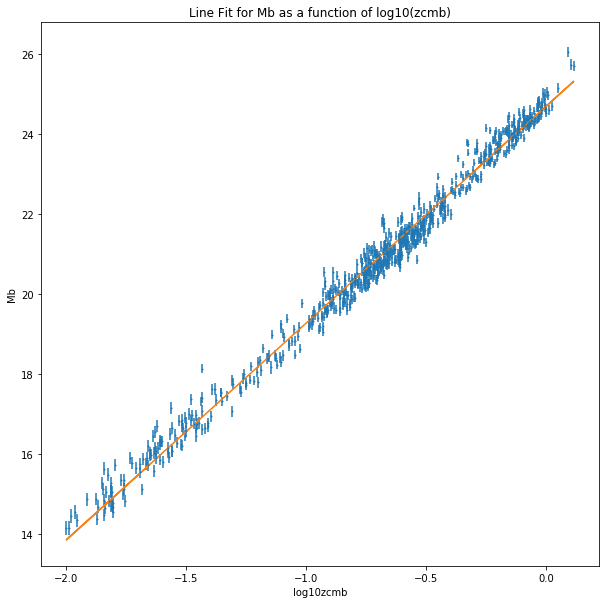

In [150]:
sortedX = np.argsort(jla['log10zcmb']);
pl.errorbar(jla['log10zcmb'], jla['mb'], yerr = jla['dmb'], fmt = ".", ms = 2, figure = pl.figure(figsize=[10,10]))
pl.plot(jla['log10zcmb'], line(jla['log10zcmb'], linOptErr[0], linOptErr[1]), "-")

pl.fill_between(jla['log10zcmb'][sortedX], 
                line(jla['log10zcmb'][sortedX], linOptErr[0] + linCovErr[0][0]**0.5, linOptErr[1] + linCovErr[1][1]**0.5),
                line(jla['log10zcmb'][sortedX], linOptErr[0] - linCovErr[0][0]**0.5, linOptErr[1] - linCovErr[1][1]**0.5), alpha=0.5)

pl.xlabel("log10zcmb")
pl.ylabel("Mb");
pl.title("Line Fit for Mb as a function of log10(zcmb)");

This figure contains the (log10zcmb, Mb) points with the linear fit containing the uncertainties. The uncertainty band is also plotted though it is small enough that it is not visible.

Compare the *model* values and uncertainty you obtained by fitting the model with and without including the uncertainties on the y values.  Comment on your findings.

Comparing the models with and without uncertainties, I see no appreciable difference in the parameters of the fit nor in the uncertainties of the parameters. This seems to indicate that the linear fit is not a strong fit as applying uncertainties to the model fails to improve the fit.

Now fit the data using only 1 every 20 points - use this: https://stackoverflow.com/questions/25876640/subsampling-every-nth-entry-in-a-numpy-array

Plot the new model and its uncertainty band and comment on the model: how do the three models compare?

In [151]:
log10zcmb20n = jla['log10zcmb'][::20]
mb20n = jla['mb'][::20]
dmb20n = jla['dmb'][::20];
linOpt20, linCov20 = opt.curve_fit(line, xdata=log10zcmb20n,ydata=mb20n,p0=[10,20],sigma=dmb20n)
print("With Uncertainties")
print("slope = {0:.1f} +/- {1:0.2} \nintercept = {2:.2} +/- {3:0.2}\nparameters covariance = {4:0.2}".format(linOpt20[0],linCov20[0][0],linOpt20[1],linCov20[1][1],linCov20[0][1]))

With Uncertainties
slope = 5.5 +/- 0.012 
intercept = 2.5e+01 +/- 0.0058
parameters covariance = 0.0067


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


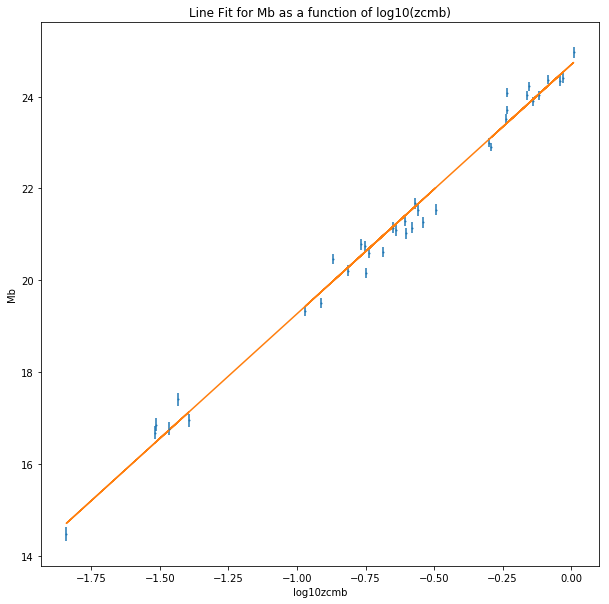

In [152]:
sortedX = np.argsort(log10zcmb20n);
pl.errorbar(log10zcmb20n, mb20n, yerr = dmb20n, fmt = ".", ms = 2, figure = pl.figure(figsize=[10,10]))
pl.plot(log10zcmb20n, line(log10zcmb20n, linOptErr[0], linOptErr[1]), "-")

pl.fill_between(jla['log10zcmb'][sortedX], 
                line(log10zcmb20n[sortedX], linOpt20[0] + linCov20[0][0]**0.5, linOpt20[1] + linCov20[1][1]**0.5),
                line(log10zcmb20n[sortedX], linOpt20[0] - linCov20[0][0]**0.5, linOpt20[1] - linCov20[1][1]**0.5), alpha=0.5);

pl.xlabel("log10zcmb")
pl.ylabel("Mb");
pl.title("Line Fit for Mb as a function of log10(zcmb)");

This figure uses a partial set of data which is plotted and fitted. The fit parameters are nearly identical as for the full set. If the linear fit is a good model we should expect that a set which also contains this and 4 times as many points should be different. Instead we should assume that the linear fit is not a good model for the data.

# Fit a quadratic equation

Use the same function ```curve_fit()``` to fit a quadratic equation to the data. 
The equation is below

Plot your data, your original model which included uncertainties, and the current quadratic model


In [0]:
def quad(x, a, b, c):
    '''Quadratic equation
    Input:
    x: array-like, the exogenous variable
    a: parameters of the quadratic term
    b: parameter of the linear term
    c: intercept
    
    '''
    return a * x**2 + b * x + c

In [154]:
quadOpt, quadCov = opt.curve_fit(quad, xdata=jla['log10zcmb'], ydata=jla['mb'] ,p0=[10,20,10], sigma=jla['dmb'])
print("With Uncertainties")
print("a = {0:.1f} +/- {1:0.2}".format(quadOpt[0], quadCov[0][0]))
print("b = {0:.2} +/- {1:0.2}".format(quadOpt[1], quadCov[1][1]))
print("c = {0:.2} +/- {1:0.2}".format(quadOpt[2],quadCov[2][2]))
print("parameters covariance = {0:0.2}".format(quadCov[1][0]))

With Uncertainties
a = 0.3 +/- 0.0017
b = 6.0 +/- 0.005
c = 2.5e+01 +/- 0.00059
parameters covariance = 0.0028


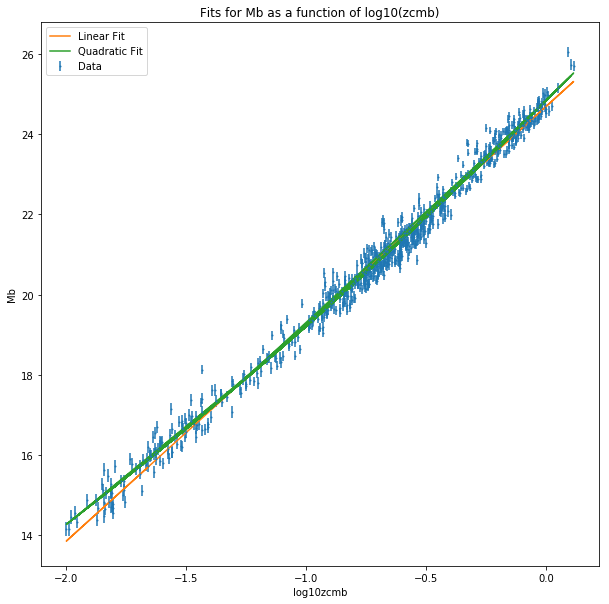

In [155]:
sortedX = np.argsort(jla['log10zcmb']);
pl.errorbar(jla['log10zcmb'], jla['mb'], yerr = jla['dmb'], fmt = ".", ms = 2, figure = pl.figure(figsize=[10,10]))
pl.plot(jla['log10zcmb'], line(jla['log10zcmb'], linOptErr[0], linOptErr[1]), "-")
pl.plot(jla['log10zcmb'], quad(jla['log10zcmb'], quadOpt[0], quadOpt[1], quadOpt[2]), "-")
pl.xlabel("log10zcmb")
pl.ylabel("Mb");
pl.title("Fits for Mb as a function of log10(zcmb)");
pl.legend(["Linear Fit", "Quadratic Fit", "Data"]);

# Now fit the data with sklearn 
like we did in class (lab 5): create a regressor linear model and fit the data to it. Predict the y values based on the input data. Make the usual plot of data and model including your baseline model with scipy

# Cross valudation: Split your data into a training and test set
this is the "signature" of the machine learning approach. While this can be done using simply a random number generator
(see example)

do it using the sklear capabilities: ```skl.model_selection.train_test_split```. Read abnout the ```stratify``` funcionality of this method: it allows you to create unbiased train-test samples. In this case it is not necessary but it may be useful in your future!


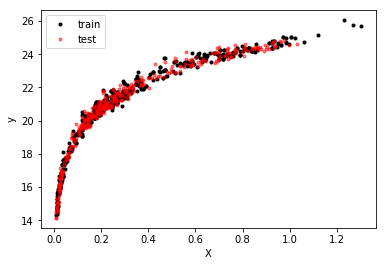

In [156]:
# handmade train-test split
Nall = len(jla)
Ntrain = int(Nall * 0.75)
train = np.random.randint(0, high=Nall, size=Ntrain)
test = np.setdiff1d(np.arange(Nall), train)
X_train, y_train = jla.zcmb[train], jla.mb[train]
X_test, y_test = jla.zcmb[test], jla.mb[test]
pl.plot(X_train, y_train, 'k.', label="train")
pl.plot(X_test, y_test, 'r.', alpha=0.5, label="test")
pl.xlabel("X")
pl.ylabel("y")
pl.legend()

In [0]:
#instead use sklern to split
X_train, X_test, y_train, y_test = sklMod.train_test_split(jla['log10zcmb'], jla['mb'], train_size = 0.67)

In [0]:
reg = sklLin.LinearRegression().fit(X_train[:, np.newaxis], y_train[:, np.newaxis]);
xfit = np.linspace(-2,0,500)
yfit = reg.predict(xfit[:, np.newaxis]);

Plot the data, the baseline mode, and the new model, but colorcode the data based on the training or test set (instead othe survey it comes from like you had done before)

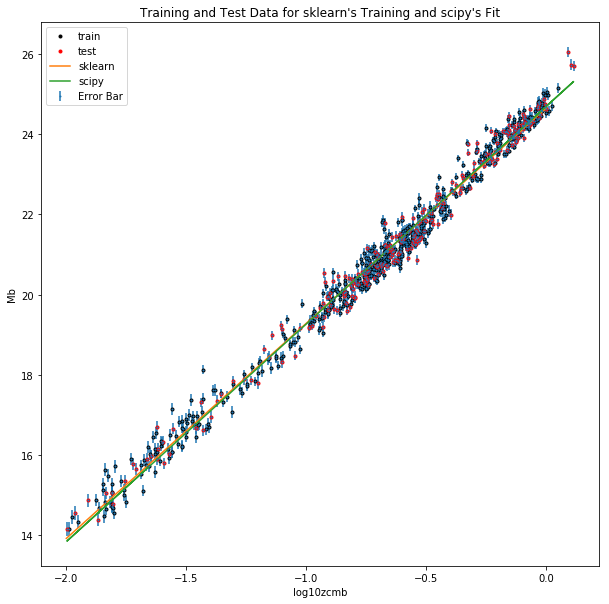

In [159]:
pl.errorbar(jla['log10zcmb'], jla['mb'], yerr = jla['dmb'], fmt = ".", ms = 2, figure = pl.figure(figsize=[10,10]), label='Error Bar')
pl.plot(X_train, y_train, 'k.', label = 'train')
pl.plot(X_test, y_test, 'r.', label = 'test')
pl.plot(xfit, yfit, label='sklearn');
pl.plot(jla['log10zcmb'], line(jla['log10zcmb'], linOptErr[0], linOptErr[1]), "-", label="scipy");
pl.legend()
pl.xlabel("log10zcmb")
pl.ylabel("Mb")
pl.title("Training and Test Data for sklearn's Training and scipy's Fit");

This figure plots the data, errorbars, the untrained scipy linear fit and the trained sklearn linear regression. The two fits are slightly different, sklearn's linear regression in orange and scipy's curve_fit in green. 

Calculate the scores of the train and test set. Make considerations about the quality of the model including how robust it is (is it overfitting?)

In [160]:
trainScore = reg.score(X_train[:, np.newaxis], y_train[:, np.newaxis])
testScore = reg.score(X_test[:, np.newaxis], y_test[:, np.newaxis])
print("The train score is {0:.2}.\nThe test score is {1:.2}.".format(trainScore, testScore))

The train score is 0.99.
The test score is 0.99.


The regression scores for the train and test data sets are about the same. Since they are so similar it is unlikely that the data is being overfit. At a score of 0.99, the model would seem to be a near-perfect fit to the data. 